# Lab 6 MCMC Rating Curves

(Derived from CEE599_bayesian_rating_curves_Lab6_v2.m)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.io as sio 

%matplotlib inline

---
#### Load in the provided data:
We're provided data in a .mat format (MATLAB's data file format). The ```scipy.io``` library has a function that allows us to read these types of files. Take a look at its documentation:

In [2]:
sio.loadmat?

Now load the Lyell canyon streamflow data:

In [3]:
data = sio.loadmat('Lyell_h_Q_sorted.mat')

What kind of data structure is our data in?

In [4]:
type(data)

dict

This is a dictionary. [Read more about python dictionaries here](https://docs.python.org/3.8/tutorial/datastructures.html#dictionaries).

In [5]:
# See what our data looks like in a dictionary data structure
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov  3 14:17:54 2015',
 '__version__': '1.0',
 '__globals__': [],
 'h1': array([[0.1805],
        [0.2197],
        [0.2406],
        [0.2407],
        [0.2565],
        [0.2822],
        [0.285 ],
        [0.2904],
        [0.2907],
        [0.2907],
        [0.2925],
        [0.3066],
        [0.3185],
        [0.3227],
        [0.3405],
        [0.3492],
        [0.3648],
        [0.3668],
        [0.3757],
        [0.3781],
        [0.3814],
        [0.383 ],
        [0.3913],
        [0.3913],
        [0.4006],
        [0.408 ],
        [0.4319],
        [0.4957],
        [0.4982],
        [0.5227],
        [0.5325],
        [0.5391],
        [0.5427],
        [0.5638],
        [0.571 ],
        [0.573 ],
        [0.6096],
        [0.6144],
        [0.6358],
        [0.6372],
        [0.6437],
        [0.644 ],
        [0.673 ],
        [0.6753],
        [0.6757],
        [0.6825],
        [0.6873],
        [0

In [6]:
# Inspect the dictionary keys
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'h1', 'Qobs1', 'date_of_obs'])

We can convert this dictionary into a pandas dataframe and select only the columns of data that we want (ignoring the file metadata):
(Even though we know, that in cases outside of the classroom, people only ignore metadata at their own peril.)

In [7]:
df = pd.DataFrame(np.hstack((data['date_of_obs'], data['h1'], data['Qobs1'])),
                  columns=['date_of_obs','h1', 'Qobs1'])
df.head()

,date_of_obs,h1,Qobs1
0,[9/26/08 16:30],0.1805,0.0778599
1,[9/19/08 0:02],0.2197,0.0719143
2,[9/10/08 21:35],0.2406,0.143829
3,[9/10/10 17:52],0.2407,0.168177
4,[8/20/07 18:22],0.2565,0.243489


And make sure our ```date_of_obs``` is being interpreted as a datetime correctly (see documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) and [here](http://strftime.org/)):

In [8]:
df['date_of_obs'] = [pd.to_datetime(dt[0], format='%m/%d/%y %H:%M') for dt in df['date_of_obs']]

In [9]:
df.head()

,date_of_obs,h1,Qobs1
0,2008-09-26 16:30:00,0.1805,0.0778599
1,2008-09-19 00:02:00,0.2197,0.0719143
2,2008-09-10 21:35:00,0.2406,0.143829
3,2010-09-10 17:52:00,0.2407,0.168177
4,2007-08-20 18:22:00,0.2565,0.243489


---
### PART 1:  Brute force parameter estimation

First, to simplify overall process, I'm pretending we know h11 (the transition between the two slopes in the rating curve) h11=0.54 EXACTLY, based on work by former M.S. student Gwyn Perry.

In [10]:
h11 = 0.54

Here, to further simplify, we will not worry about the break point, and we will look only at the flows above h1=0.54.

Identify the rows in our data frame that correspond to flows with h1 > h11, these correspond to data above the change in channel control.

In [11]:
Qobs_now = df.Qobs1[df.h1 > h11]
h_now = df.h1[df.h1 > h11]

For this example, my priors are uniform. As shown in the lecture slides, I will sample the space and not use a random number generator for the first go around.

Recall that we are trying to solve for a, b, and c in the equation
$Q = a(h-b)^c$

I'll just take 10 values out of each uniform distribution.

In [12]:
nx=10
# for c, we know that at higher flows (which we've restricted our sample to), c = 5/3 or 1.67
# We allow c to vary slightly around this theoretical value
c = np.linspace(1.67-0.05,1.67+0.05,nx)
# b is an empirical constant of where the upper level equation intersects 0 
# b only represents the true 0 level for the lower portion of the rating curve equation
# here, we guess a range of values based on visual inspection of our data
b = np.linspace(0.15,0.45,nx)
# a can be estimated as a function of channel slope and roughness (see paper by LeCoz et al.)
# for now, we will just guess a range of values that seem reasonable by visual inspection
a = np.linspace(5,50,nx)

In [13]:
# Set up the arrays we'll populate with data below
Qest = np.ones((10,10,10,h_now.size)) # for estimating Q with each parameter set
Qfit = np.ones((10,10,10)) # for RMSE values

In [14]:
# Iterate through all combinations of a, b, and c parameters
# Then calculate Qest, and Qfit (RMSE)

for ic in range(nx):
    for ib in range(nx):
        for ia in range(nx):
            Qest[ia,ib,ic,:] = a[ia] * (h_now-b[ib])**c[ic]
            temp = np.reshape(Qest[ia,ib,ic,:],Qobs_now.size)
            Qfit[ia,ib,ic]=np.sqrt( np.mean( (temp-Qobs_now)**2 ) ) # calculate RMSE for this parameter set


#### Make some plots to see what this did
Which parameters seemed the best?

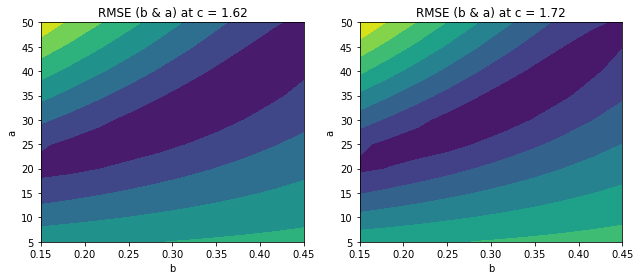

In [15]:
f, ax = plt.subplots(1,2,figsize=(9,4))
ic = 0 # select the first value of c
Qfit_temp = np.reshape(Qfit[:,:,ic],[10,10]);
ax[0].contourf(b,a,Qfit_temp)
ax[0].set_xlabel('b')
ax[0].set_ylabel('a')
ax[0].set_title('RMSE (b & a) at c = {}'.format(np.round(c[ic],2)))

ic = -1 # the last value of c (using the index "-1" to represent the last value in the array)
Qfit_temp2 = np.reshape(Qfit[:,:,ic],[10,10]);
ax[1].contourf(b,a,Qfit_temp2)
ax[1].set_xlabel('b')
ax[1].set_ylabel('a')
ax[1].set_title('RMSE (b & a) at c = {}'.format(np.round(c[ic],2)))

f.tight_layout()

From the above, we can see that c makes a relatively slight difference, but a and b vary with each other quite a bit.

####  And then plot this as rating curves to see how our different parameter choices impact the spread c in estimated discharge as a function of h

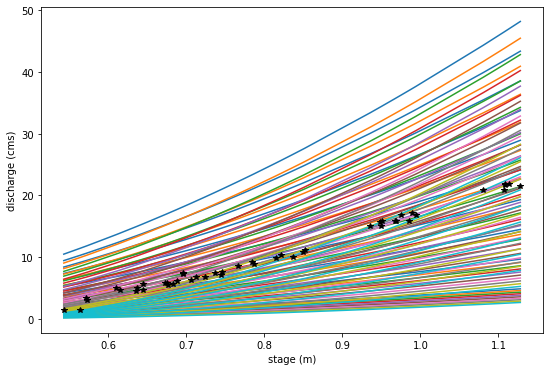

In [16]:
plt.figure(figsize=(9,6))
# Note, because c doesn't matter much, we will just choose a c value from the middle

for ia in range(nx):
    for ib in range(nx):
        plt.plot(h_now,np.reshape(Qest[ia,ib,5,:],h_now.size))

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*')

#### Now say we ony want to sort those realizations according to RMSE.  (Clearly some curves are better than others)

In [17]:
# Reshape Qfit and Qest for a single c value to only look at variations of a and b
ic = 5
Qfit2 = np.reshape(Qfit[:,:,ic],[10,10])
Qest2 = np.reshape(Qest[:,:,ic,:],[10,10,h_now.size])

# Find the corresponding Qest values for different ranges of RMSE
Qest_rmse1 = Qest2[Qfit2<1]                # RMSE < 1
Qest_rmse3 = Qest2[(Qfit2>=1) & (Qfit2<3)] # 1 <= RMSE < 3
Qest_rmse5 = Qest2[(Qfit2>=3) & (Qfit2<5)] # 3 <= RMSE < 5

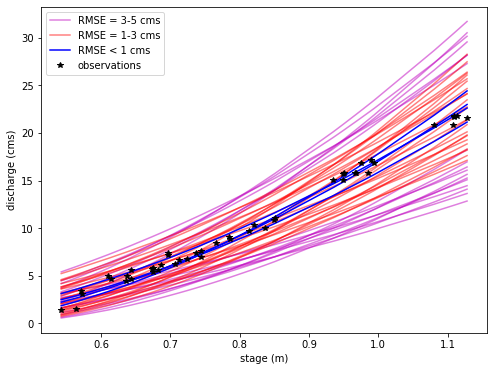

In [18]:
plt.figure(figsize=(8,6))

# Plot the rating curves with RMSE between 3 and 5 cms
for i in range(Qest_rmse5.shape[0]):
    if i ==0:
        label='RMSE = 3-5 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse5[i],'m',alpha=0.5,label=label)
    
# Plot the rating curves with RMSE between 1 and 3 cms
for i in range(Qest_rmse3.shape[0]):
    if i ==0:
        label='RMSE = 1-3 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse3[i],'r',alpha=0.5,label=label)
    
# Finally plot the rating curves with RMSE < 1 cms
for i in range(Qest_rmse1.shape[0]):
    if i ==0:
        label='RMSE < 1 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse1[i],'b',alpha=1,label=label)

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*',label='observations')
plt.legend();

Note that what we're starting to do here is to sort our rating curve parameter space into more likely and less likely parameter sets, based on how well they fit the data.  However, this is imprecise, and we cannot quantify 95% uncertainty limits in any discharge estimation.

---
# PART 2:  Use MCMC to sample the parameter space.  

With uniform priors, this is very similar to the part 1 parameter estimation problem.

So, the above gives us an idea of Monte-Carlo parameter estimation but does not illustrate Bayesian or MCMC routines

I'm going to simplify to a two parameter problem, where I say that c=1.66 and that I know that (okay, not exactly true but it seemed to matter the least in this particular problem), and I'm going to start with the expected values from my priors for my initial guess.


In [19]:
b0 = 0.2833
a0 = 25
c0 = 1.66 # and this one I won't vary

Now, we will ask the computer to navigate the parameter space.  I will determine where to go according to how well my modeled Q fits my observed Q at all of my measurement points, with the understanding that the parameters that give me the minimum error are most likely to be true.

initial guess = likelihood = P(Q|theta), that's our model compared to our obs -- only need relative sense of error, so we look at the SSE's

In [20]:
Qest0 = a0 * (h_now-b0)**c0
SSE0 = np.sum((Qest0-Qobs_now)**2)
SSE0

162.11937034185863

Now, in the bayesian sense, we have to multiply this by the liklihood of our parameters P(theta) -- if I ignore normalization for now, I currently have uniform priors, so if a and b fall within my range, P0 is 1, and if either falls out of my range, P0 is 0 (not possible).
(Note that this is the simplest case.  If we had a normal distribution for the prior, we would multiply that by the liklihood as we did in lab 5.)

In [21]:
# So, I set my limits of my uniform distribution
amin = 5
amax = 50
bmin = 0.15
bmax = 0.45

# for first step, I know I picked values in with the range, so 
P0 = 1

In [22]:
Lmc = 10000 #number of steps to run MCMC routine for.
burn_in = 1000 #estimate the number of steps before Markov Chain becomes stationary
# basically, the burn-in steps will not be used in calculating final probabilities because 
# they depend on the initial parameter estimates.

# Initialize arrays to store results in
PthetaQ = np.ones((Lmc,1))
amc = np.zeros((Lmc,1))
bmc = np.zeros((Lmc,1))

And we can calculate P(theta|Q).  
Note that we are defining this by our goodness-of-fit statistic.  Here, we use the sum of squared errors, where if it is smaller, P(theta|Q) is greater, and the choice is a better fit.

In [23]:
PthetaQ[0] = SSE0*P0 # this is our starting point.
    # Note that this calculation is not a true probability of P(theta|Q) but a relative metric
amc[0] = a0
bmc[0] = b0
# We save all the values at each step.

Now we start marching in MCMC space...

I need to randomly pick a new location.  This is art, so I'm going to use two gaussians around my current location with sigma equal to the half-width of my prior distribution to pick a test jump location. I will use a Gibbs approach and jump in one variable followed by the other each time.  (Note that a lot of the active research in MCMC code involves both how you pick your initial position and in how you pick your jumping strategy.)

I'm going to assume that my two parameters are totally independent (probably not true -- a next step would be to try a bivariate gaussian, but we stick with the simple case).

In [ ]:
for imc in range(1,Lmc):
    
        # first we jump in a
    newjumpa = amc[imc-1] + (amax-amin)/(10*np.random.normal())
    
        # Now we repeat with a jump in b, assuming it's totally independent of a
        # and require both to be within their uniform distributions. 
        
    newjumpb = bmc[imc-1] + (bmax-bmin)/(10*np.random.normal())
    
    if (newjumpa >= amin) and (newjumpa <= amax) and (newjumpb >= bmin) and (newjumpb <= bmax):
        #then the prior is okay, and we can proceed 
        # (Note that prior makes any choice outside of our set range impossible)
        Qest1 = newjumpa*(h_now-newjumpb)**c0
        
        # calculate how well the parameters at our new location lead to a model that matches the data
        SSE1=np.sum((Qest1-Qobs_now)**2)
        
        # posterior is SSE1*1 (because we're within the prior uniform domain)
        # the if statement essentially says everything else is multiplied by 0
        
        if SSE1 < PthetaQ[imc-1]:
            # then the error is less, and we found a better place, and we update a and b
            amc[imc] = newjumpa
            bmc[imc] = newjumpb
            PthetaQ[imc] = SSE1 # this becomes the one to beat
        else:
            jumpscore = PthetaQ[imc-1]/SSE1 # this gives a number between 0 and 1
            
            # This is essentially a rating of how much worse this new location is than 
            # where you are right now.  The sum of squared errors is larger, but by how much
            
            # Generate random number from 0 to 1, so that we will jump with a probability of 
            # the jumpscore
            # if our new SSE is 90% as good as our current one, we jump there 90% of the time; 
            # if it's 10% as good, we jump there 10% of the time
            if np.random.uniform() <= jumpscore:
                # then we go there
                amc[imc] = newjumpa
                bmc[imc] = newjumpb
                PthetaQ[imc] = SSE1 # this becomes the one to beat
            else:
                amc[imc]=amc[imc-1]
                bmc[imc]=bmc[imc-1]
                PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are for another timestep

    else:
    # you are outside of the bounds of the uniform prior, so posterior would be 0 and we don't go there
        amc[imc]=amc[imc-1]
        bmc[imc]=bmc[imc-1]
        PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are


#### Make some plots to see what's going on

In [ ]:
# Visualize all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.plot(bmc,amc,'b.--',alpha=0.2,label='All jumps')
# Visualize the first 20 jumps
plt.plot(bmc[:20],amc[:20],'k.-',alpha=1,label='First 20 jumps')
# Visualize the last 20 jumps
plt.plot(bmc[-20:],amc[-20:],'r.-',alpha=1,label='Last 20 jumps')
plt.xlabel('b')
plt.ylabel('a')
plt.legend();

In [ ]:
# "Heatmap" of all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.hist2d(bmc.ravel(),amc.ravel(),30);
plt.xlabel('b')
plt.ylabel('a');

#### Make some PDFs

Remember that there is a burn-in time, so only calculate stats for steps after the burn_in value.  (This is to avoid infuencing final statistics from the choice of the initial state.)

In [ ]:
# What are the marginal PDFs for a and b?
a = plt.hist(amc[burn_in:],20);
b = plt.hist(bmc[burn_in:],20);
plt.close();

f, ax = plt.subplots(2,1,figsize=(7,7))
# A
ax[0].plot(a[1][:-1],a[0]/(np.sum(a[0])*(a[1][1]-a[1][0])),'b')
ax[0].set_xlabel('a')
ax[0].set_ylabel('posterior PDF of a')
# B
ax[1].plot(b[1][:-1],b[0]/(np.sum(b[0])*(b[1][1]-b[1][0])),'r')
ax[1].set_xlabel('b')
ax[1].set_ylabel('posterior PDF of b')
f.tight_layout()

#### What are the 95% confidence intervals for the predicted Q
Note that by virtue of how we set up the jumping rules, the "jumper" spent more time in the good-fitting parameter space than in more poorly-fitting parameter space.  Even better, it spent exactly as much time in the more poorly-fitting space as measured by how much worse it performed.  By this structure, all calculated values of Q after the burn-in time are distributed by their liklihood of being right.

In [ ]:
# evenly space 25 stage values (could have more if doesn't look smooth)
hh=np.linspace(0.54,1.5,25) 

# Make an empirical CDF for all calculated values of Q using a and b after the burn-in time 
# and plot the median and 95% confidence values from the Markov Chain generated probabilities
NN=amc[burn_in:].size

In [ ]:
Q025 = np.ones((hh.shape))
Q50 = np.ones((hh.shape))
Q975 = np.ones((hh.shape))

for ih in range (hh.size):
    Qhh = amc[burn_in:]*(hh[ih]-bmc[burn_in:])**c0
    xsort = np.sort(Qhh[:,0])
    ranks = np.array(range(NN))+1
    x_CDF = 1 - (ranks - 0.4)/(NN + 0.2)
    
    Q025[ih] = np.interp(0.025,1-x_CDF,xsort)
    Q975[ih] = np.interp(0.975,1-x_CDF,xsort)
    Q50[ih] = np.interp(0.5,1-x_CDF,xsort)

Plot the median and 95% confidence values from the Markov Chain generated probabilities

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(hh,Q025,'r--',label='95% confidence intervals')

plt.plot(hh,Q975,'r--')
plt.plot(hh,Q50,'k-',label='best guess')
plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'b*',label='observations')
plt.legend()
plt.title('Best estimate with 95% confidence intervals')

#### And extra thank you to Steven for converting all of this from Matlab to Python.